# Natural Language Processing

This is a project that aims to employ several methods of natural language processing. 

The objective is to join the patients and the clinical trials that make sense together. 

This includes: vector space model, language model with Jelineck Mercer smoother, linear regression and Bert.

## Base pipeline

1- Setting groundtruth and queries


In [1]:
import xml.etree.ElementTree as ET
import matplotlib as plt
import pandas as pd
import numpy as np
import trec
import pprint as pp
import pickle

Qrels = "qrels-clinical_trials.txt"

Queries = "topics-2014_2015-summary.topics"


with open(Queries, 'r') as queries_reader:
    txt = queries_reader.read()

root = ET.fromstring(txt)

cases = {}
cases_age = {}
cases_genre = {}
for query in root.iter('TOP'):
    q_num = query.find('NUM').text
    q_title = query.find('TITLE').text
    cases[q_num] = q_title
    #cases_age[q_num] = query.find('AGE').text
    #cases_genre[q_num] = query.find('GENDER').text

eval = trec.TrecEvaluation(cases, Qrels)


pickle.dump(cases, open("cases.bin", "wb"))
pickle.dump(cases_age, open("cases_age.bin", "wb"))
pickle.dump(cases_genre, open("cases_genre.bin", "wb"))


2 -Getting Clinical trials info


In [3]:
import xml.etree.ElementTree as ET
import tarfile

tar = tarfile.open("clinicaltrials.gov-16_dec_2015.tgz", "r:gz")
doc_ids = []
brief_titles = []
detailed_descriptions = []
brief_summaries = []
criterias = []
genders = []
minimum_ages = []
maximum_ages = []

namelist = tar.getnames()

for tarinfo in tar:
    if tarinfo.size > 500:
        txt = tar.extractfile(tarinfo).read().decode("utf-8", "strict")
        root = ET.fromstring(txt)
        judged = False
        id=''
        bt=''
        dt=''
        bs=''
        cs=''
        ge=''
        ma=''
        mi=''

        for doc_id in root.iter('nct_id'):
            if doc_id.text in eval.judged_docs:
                judged = True
                id=doc_id.text.strip()
                break
                
        if judged is False:
            continue

        brief_title = root.find('brief_title').text.strip()
        bt=brief_title

        for dd in root.iter('detailed_description'):
            for child in dd:
                dd=child.text.strip()
        if dd == '':
            dd=brief_title
              
        for bs in root.iter('brief_summary'):
            for child in bs:
                bs=child.text.strip()
        if bs == '':
            bs=brief_title
                
        for c in root.iter('criteria'):
            for child in c:
                cs=child.text.strip()
        if cs=='':
            cs= brief_title

        for gender in root.iter('gender'):
            ge=gender.text.strip()
        if ge=='' or ge=='N/A':
            ge='Both'

        for minimum_age in root.iter('minimum_age'):
            mi=minimum_age.text.strip()
        if mi=='' or mi=='N/A':
            mi='0 years'

        for maximum_age in root.iter('maximum_age'):
            ma=maximum_age.text.strip()
        if ma=='' or ma=='N/A':
            ma='100 years'

       
        if id!='' and bt!='' and dd!='' and bs!='' and cs!='' and ge!='' and mi!='' and ma!='':
            doc_ids.append(id)
            brief_titles.append(bt)
            detailed_descriptions.append(dd)
            brief_summaries.append(bs)
            criterias.append(cs)
            genders.append(ge)
            minimum_ages.append(mi)
            maximum_ages.append(ma)
            #print('passed')
        else:
            print('failed')
            print(id,bt,dd,bs,cs)
            continue

        if len(doc_ids) != len(brief_titles) or len(detailed_descriptions) != len(brief_summaries) or len(brief_summaries) != len(criterias):
            print("error")
            print(brief_title)
            print(detailed_descriptions[0].text.strip())
            print(brief_summaries[0].text.strip())
            print(criterias[0].text.strip())
            break
tar.close()

print('ids',len(doc_ids))
print('bt', len(brief_titles))
print('dd',len(detailed_descriptions))
print('bs',len(brief_summaries))
print('c',len(criterias))
print('g', len(genders))
print('mina',len(minimum_ages))
print('maa',len(maximum_ages))

pickle.dump(doc_ids, open("doc_ids.bin", "wb"))
pickle.dump(brief_titles, open("brief_title.bin", "wb"))
pickle.dump(detailed_descriptions, open("detailed_description.bin", "wb"))
pickle.dump(brief_summaries, open("brief_summary.bin", "wb"))
pickle.dump(criterias, open("criteria.bin", "wb"))
pickle.dump(genders, open("gender.bin", "wb"))
pickle.dump(minimum_ages, open("minimum_age.bin", "wb"))
pickle.dump(maximum_ages, open("maximum_age.bin", "wb"))


KeyboardInterrupt: 

3 -Defining abstract class RetrievalModel


In [ ]:
import abc  # é preciso importar isto quando queremos definir uma classe abstrata


class RetrievalModel:  # vamos criar uma classe abstrata que é o molde para todas as nossas classes, cada uma um modelo
    @abc.abstractmethod  # para sabermos que RetrievalModel é uma classe abstrata e que, portanto, não pode ser instanciada, ie, "concretizada"
    def search(self):  # aqui nomeia-se uma das funcoes desta classe, neste caso, aquela onde vamos por o codigo q ordenava os docs e ainda classificava a performance do nosso modelo (junto para nao termos q mudar tanto o codigo)
        pass  # nao se pode por nada aqui na abstrata, apenas em cada classe "filho" é que se define a função, aqui apenas se nomeia


## Vector Space Model

4-VSM Unigram


In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer


class VSM(RetrievalModel):  # definimos a classe de um dos modelos e pomos o RetrievalModel para dizer q esta classe é uma subclasse da classe abstrata
    def search(self, caseid, docs):  # aqui definimos a funcao que faz tudo o q o nosso modelo fazia, pus o codigo ca dentro, pus self.doc em vez de docs
        index = TfidfVectorizer(ngram_range=(
            1, 1), analyzer='word', stop_words=None)
        index.fit(docs)
        X = index.transform(docs)
        query = cases[caseid]
        query_tfidf = index.transform([query])
        doc_scores = 1-pairwise_distances(X, query_tfidf, metric='cosine')
        scores = doc_scores.tolist()
        return scores


## Language Model with Jelineck Mercer Smoother

5-LMJM Unigram


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from collections import Counter

brief_summary = pickle.load(open("brief_summary.bin", "rb"))

# print(cases)


class LMJM(RetrievalModel):
    def search(self, caseid, docs):
        index = CountVectorizer(ngram_range=(1, 1), analyzer='word')
        corpus_cv = index.fit(docs).transform(docs)
        lmbd = 0.8
        prob_word_docs = corpus_cv/np.sum(corpus_cv, axis=1)  # p(t|md)
        prob_word_corpus = np.sum(corpus_cv, axis=0) / \
            np.sum(corpus_cv)  # p(t|mc)
        log_mixture = np.log(lmbd*prob_word_docs + (1-lmbd)*prob_word_corpus)
        query = cases[caseid]
        query_cv = index.transform([query])
        total = log_mixture*query_cv.T
        return total


6-Import relevant documents and libraries


In [19]:
import pickle
import trec
import numpy as np

# Aqui abrimos cada documento pickle e damos-lhes os nomes para usar nas funcoes seguintes
ids = pickle.load(open("doc_ids.bin", "rb"))
brief_title = pickle.load(open("brief_title.bin", "rb"))
detailed_description = pickle.load(open("detailed_description.bin", "rb"))
brief_summary = pickle.load(open("brief_summary.bin", "rb"))
criteria = pickle.load(open("criteria.bin", "rb"))
gender = pickle.load(open("gender.bin", "rb"))
minimum_age = pickle.load(open("minimum_age.bin", "rb"))
maximum_age = pickle.load(open("maximum_age.bin", "rb"))
cases = pickle.load(open("cases.bin", "rb"))
genders = pickle.load(open("gender.bin", "rb"))
minimum_ages = pickle.load(open("minimum_age.bin", "rb"))
maximum_ages = pickle.load(open("maximum_age.bin", "rb"))


7-Setting models and text fields


In [ ]:
models = [VSM(), LMJM()]
fields = [brief_title, detailed_description, brief_summary, criteria]

8-Separate training and test queries


In [20]:
print("cases length: ", len(cases))
cases_training = []
cases_test = []
i = 0
k = 12
for caseid in cases:
    if i < len(cases)-k:
        cases_training.append(caseid)
    else:
        cases_test.append(caseid)
    i += 1

print("training queries length: ", len(cases_training))
print("test queries length: ", len(cases_test))


pickle.dump(cases_training, open("cases_training.bin", "wb"))
pickle.dump(cases_test, open("cases_test.bin", "wb"))


cases length:  60
training queries length:  48
test queries length:  12


9-Getting scores for pairs query_doc for each model and text field


In [ ]:
# buscar listas
queries_training = []
docs_training = []
VSM_bt_training = []
VSM_dd_training = []
VSM_bs_training = []
VSM_cr_training = []
LMJM_bt_training = []
LMJM_dd_training = []
LMJM_bs_training = []
LMJM_cr_training = []
y_training = []

for caseid in cases_training:
    case_rel = []
    field_ind = 0
    aux = eval.relevance_judgments.loc[eval.relevance_judgments['query_id'] == int(
        caseid)]
    docs = aux['docid'].tolist()
    for docid in docs:
        case_rel.append(ids.index(docid))
    relevances = aux['rel'].tolist()
    for rel in relevances:
        if rel == 0:
            y_training.append(rel)
        elif rel == 1 or rel == 2:
            y_training.append(1)
    for model in models:
        for field in fields:
            scores = model.search(caseid, field)
            for rel in case_rel:
                value = scores[rel]
                if field_ind == 0:
                    queries_training.append(caseid)
                    docs_training.append(rel)
                    VSM_bt_training.append(value[0])
                elif field_ind == 1:
                    VSM_dd_training.append(value[0])
                elif field_ind == 2:
                    VSM_bs_training.append(value[0])
                elif field_ind == 3:
                    VSM_cr_training.append(value[0])
                elif field_ind == 4:
                    LMJM_bt_training.append(value[0])
                elif field_ind == 5:
                    LMJM_dd_training.append(value[0])
                elif field_ind == 6:
                    LMJM_bs_training.append(value[0])
                elif field_ind == 7:
                    LMJM_cr_training.append(value[0])
            field_ind += 1

print("VSM_brief_title_training: ", len(VSM_bt_training))
print("VSM_detailed_description_training: ", len(VSM_dd_training))
print("VSM_brief_summary_training: ", len(VSM_bs_training))
print("VSM_criteria_training: ", len(VSM_cr_training))
print("LMJM_brief_title_training: ", len(LMJM_bt_training))
print("LMJM_detailed_description_training: ", len(LMJM_dd_training))
print("LMJM_brief_summary_training: ", len(LMJM_bs_training))
print("LMJM_criteria_training: ", len(LMJM_cr_training))
print("y_training: ", len(y_training))


VSM_brief_title_training:  3296
VSM_detailed_description_training:  3296
VSM_brief_summary_training:  3296
VSM_criteria_training:  3296
LMJM_brief_title_training:  3296
LMJM_detailed_description_training:  3296
LMJM_brief_summary_training:  3296
LMJM_criteria_training:  3296
y_training:  3296


10- Normalize scores and create dataframe

In [ ]:
#normalize
VSM_bt_training_norm = [(float(i)-min(VSM_bt_training))/(max(VSM_bt_training)-min(VSM_bt_training)) for i in VSM_bt_training]
VSM_dd_training_norm = [(float(i)-min(VSM_dd_training))/(max(VSM_dd_training)-min(VSM_dd_training)) for i in VSM_dd_training]
VSM_bs_training_norm = [(float(i)-min(VSM_bs_training))/(max(VSM_bs_training)-min(VSM_bs_training)) for i in VSM_bs_training]
VSM_cr_training_norm = [(float(i)-min(VSM_cr_training))/(max(VSM_cr_training)-min(VSM_cr_training)) for i in VSM_cr_training]
LMJM_bt_training_norm = [(float(i)-min(LMJM_bt_training))/(max(LMJM_bt_training)-min(LMJM_bt_training)) for i in LMJM_bt_training]
LMJM_dd_training_norm = [(float(i)-min(LMJM_dd_training))/(max(LMJM_dd_training)-min(LMJM_dd_training)) for i in LMJM_dd_training]
LMJM_bs_training_norm = [(float(i)-min(LMJM_bs_training))/(max(LMJM_bs_training)-min(LMJM_bs_training)) for i in LMJM_bs_training]
LMJM_cr_training_norm = [(float(i)-min(LMJM_cr_training))/(max(LMJM_cr_training)-min(LMJM_cr_training)) for i in LMJM_cr_training]

candidates = {'query': queries_training,
              'doc': docs_training,
              'VSM_bt': VSM_bt_training_norm,
              'VSM_dd': VSM_dd_training_norm,
              'VSM_bs': VSM_bs_training_norm,
              'VSM_cr': VSM_cr_training_norm,
              'LMJM_bt': LMJM_bt_training_norm,
              'LMJM_dd': LMJM_dd_training_norm,
              'LMJM_bs': LMJM_bs_training_norm,
              'LMJM_cr': LMJM_cr_training_norm,
              'Y': y_training
              }
df = pd.DataFrame(candidates, columns=['query', 'doc',
                                       'VSM_bt', 'VSM_dd', 'VSM_bs', 'VSM_cr', 'LMJM_bt', 'LMJM_dd', 'LMJM_bs', 'LMJM_cr', 'Y'])


## Logistic Regression

11-Logistic Regression cross validation to find best C


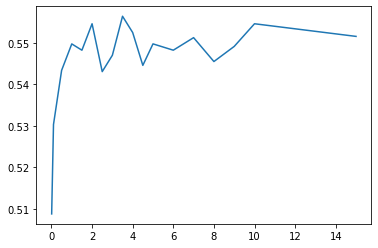

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
#from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

x = df[['VSM_bt', 'VSM_dd', 'VSM_bs', 'VSM_cr',
        'LMJM_bt', 'LMJM_dd', 'LMJM_bs', 'LMJM_cr']]
y = df['Y']
c_values = [0.01, 0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6,7,8,9 ,10, 15]
c_ap = []
k = 5
kf = KFold(n_splits=k, random_state=None, shuffle=True)

for c in c_values:
    acc_score = []
    for train_index, test_index in kf.split(x):
        X_train, X_test = x.iloc[train_index, :], x.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        clf = LogisticRegression(
            random_state=0, C=c, class_weight='balanced').fit(X_train, y_train)
        pred_values = clf.predict(X_test)
        acc = accuracy_score(pred_values, y_test)
        acc_score.append(acc)
    avg_acc_score = sum(acc_score)/k
    c_ap.append(avg_acc_score)

plt.plot(c_values, c_ap)


11-Training Logistic Regression with best C value


In [ ]:
clf = LogisticRegression(
    random_state=0, C=2, class_weight='balanced').fit(x, y)
coefs = clf.coef_[0]
print('Coefs: {}'.format(coefs))

Coefs: [-0.66321698 -0.03321505 -0.51703492 -0.26911082  0.00534964 -0.01012452
  0.00412697  0.00276404]


12-Eval scores for docs that are judged for a given test query:


In [ ]:
p10_list = []
recall_list = []
ap_list = []
ndcg5_list = []
mrr_list = []

for caseid in cases_test:
    VSM_bt_test = []
    VSM_dd_test = []
    VSM_bs_test = []
    VSM_cr_test = []
    LMJM_bt_test = []
    LMJM_dd_test = []
    LMJM_bs_test = []
    LMJM_cr_test = []
    y_test = []
    case_rel = []
    field_ind = 0
    zs = []
    aux = eval.relevance_judgments.loc[eval.relevance_judgments['query_id'] == int(
        caseid)]
    docs = aux['docid'].tolist()
    relevances = aux['rel'].tolist()
    for rel in relevances:
        if rel == 0:
            y_test.append(rel)
        elif rel == 1 or rel == 2:
            y_test.append(1)
    for docid in docs:
        case_rel.append(ids.index(docid))
    for model in models:
        for field in fields:
            scores = model.search(caseid, field)
            for rel in case_rel:
                value = scores[rel]
                if field_ind == 0:
                    VSM_bt_test.append(value[0])
                elif field_ind == 1:
                    VSM_dd_test.append(value[0])
                elif field_ind == 2:
                    VSM_bs_test.append(value[0])
                elif field_ind == 3:
                    VSM_cr_test.append(value[0])
                elif field_ind == 4:
                    LMJM_bt_test.append(value[0])
                elif field_ind == 5:
                    LMJM_dd_test.append(value[0])
                elif field_ind == 6:
                    LMJM_bs_test.append(value[0])
                elif field_ind == 7:
                    LMJM_cr_test.append(value[0])
            field_ind += 1
            
    for line in range(0, len(VSM_bt_test)):
        z = coefs[0]*VSM_bt_test[line]+coefs[1]*VSM_dd_test[line] + coefs[2]*VSM_bs_test[line]+coefs[3]*VSM_cr_test[line] + \
            coefs[4]*LMJM_bt_test[line]+coefs[5]*LMJM_dd_test[line] + \
            coefs[6]*LMJM_bs_test[line]+coefs[7]*LMJM_cr_test[line]
        zs.append(z)

    doc_ids = []
    for pos in case_rel:
        doc_ids.append(ids[pos])

    cand = {'_id': doc_ids, 'score': zs}
    results = pd.DataFrame(cand, columns=['_id', 'score'])
    results.sort_values(by=['score'], inplace=True, ascending=False)
    [p10, recall, ap, ndcg5, mrr] = eval.eval(results, caseid)
    [precision_11point, recall_11point,
        total_relv_ret] = eval.evalPR(results, caseid)

    p10_list += [p10]
    recall_list += [recall]
    ap_list += [ap]
    ndcg5_list += [ndcg5]
    mrr_list += [mrr]

print("Scores of relevant docs for test cases:")
print("P10", np.mean(p10_list))
print("Recall", np.mean(recall_list))
print("AP", np.mean(ap_list))
print("NDCG5", np.mean(ndcg5_list))
print("MRR", np.mean(mrr_list))


Scores of relevant docs for test cases:
P10 0.17500000000000002
Recall 1.0
AP 0.24794054532156182
NDCG5 0.12713573123234226
MRR 0.2150800309473823


13-Eval scores for all docs given test queries


In [ ]:
p10_list = []
recall_list = []
ap_list = []
ndcg5_list = []
mrr_list = []

avg_precision_11point = np.zeros(11)

for caseid in cases_test:
    VSM_bt_test = []
    VSM_dd_test = []
    VSM_bs_test = []
    VSM_cr_test = []
    LMJM_bt_test = []
    LMJM_dd_test = []
    LMJM_bs_test = []
    LMJM_cr_test = []
    field_ind = 0
    zs = []
    for model in models:
        for field in fields:
            scores = model.search(caseid, field)
            for id in range(0, len(ids)):
                value = scores[id]
                if field_ind == 0:
                    VSM_bt_test.append(value[0])
                elif field_ind == 1:
                    VSM_dd_test.append(value[0])
                elif field_ind == 2:
                    VSM_bs_test.append(value[0])
                elif field_ind == 3:
                    VSM_cr_test.append(value[0])
                elif field_ind == 4:
                    LMJM_bt_test.append(value[0])
                elif field_ind == 5:
                    LMJM_dd_test.append(value[0])
                elif field_ind == 6:
                    LMJM_bs_test.append(value[0])
                elif field_ind == 7:
                    LMJM_cr_test.append(value[0])
            field_ind += 1

    for line in range(0, len(VSM_bt_test)):
        z = coefs[0]*VSM_bt_test[line]+coefs[1]*VSM_dd_test[line] + coefs[2]*VSM_bs_test[line]+coefs[3]*VSM_cr_test[line] + \
            coefs[4]*LMJM_bt_test[line]+coefs[5]*LMJM_dd_test[line] + \
            coefs[6]*LMJM_bs_test[line]+coefs[7]*LMJM_cr_test[line]
        zs.append(z)

    cand = {'_id': ids, 'score': zs}
    results = pd.DataFrame(cand, columns=['_id', 'score'])
    results.sort_values(by=['score'], inplace=True, ascending=False)

    [p10, recall, ap, ndcg5, mrr] = eval.eval(results, caseid)
    [precision_11point, recall_11point,
        total_relv_ret] = eval.evalPR(results, caseid)

    p10_list += [p10]
    recall_list += [recall]
    ap_list += [ap]
    ndcg5_list += [ndcg5]
    mrr_list += [mrr]

print("Scores of all docs for test cases:")
print("P10", np.mean(p10_list))
print("Recall", np.mean(recall_list))
print("AP", np.mean(ap_list))
print("NDCG5", np.mean(ndcg5_list))
print("MRR", np.mean(mrr_list))


Scores of all docs for test cases:
P10 0.025000000000000005
Recall 1.0
AP 0.009947245714695598
NDCG5 0.014131591792902345
MRR 0.003125574554145983


14-Eval scores for all docs given test queries with filters


In [ ]:
q_age = []
d_min_age = []
d_max_age = []


for case in cases_age:
    #print(case)
    q_age.append(cases_age[case].split(' ')[0])

for case in minimum_ages:
    d_min_age.append(case.split(' ')[0])

for case in maximum_ages:
    d_max_age.append(case.split(' ')[0])



In [ ]:
p10_list = []
recall_list = []
ap_list = []
ndcg5_list = []
mrr_list = []

avg_precision_11point = np.zeros(11)
j=0
for caseid in cases_test:
    new_ids = []
    VSM_bt_test = []
    VSM_dd_test = []
    VSM_bs_test = []
    VSM_cr_test = []
    LMJM_bt_test = []
    LMJM_dd_test = []
    LMJM_bs_test = []
    LMJM_cr_test = []
    field_ind = 0
    zs = []
    for model in models:
        for field in fields:
            scores = model.search(caseid, field)
            for id in range(0, len(ids)-1):
                # filters
                if int(q_age[j]) <= int(d_max_age[id]) and int(q_age[j]) >= int(d_min_age[id]) and (cases_genre[caseid] == genders[id] or genders[id] == 'Both'):
                    value = scores[id]
                    if field_ind == 0:
                        VSM_bt_test.append(value[0])
                        new_ids.append(ids[id])
                    elif field_ind == 1:
                        VSM_dd_test.append(value[0])
                    elif field_ind == 2:
                        VSM_bs_test.append(value[0])
                    elif field_ind == 3:
                        VSM_cr_test.append(value[0])
                    elif field_ind == 4:
                        LMJM_bt_test.append(value[0])
                    elif field_ind == 5:
                        LMJM_dd_test.append(value[0])
                    elif field_ind == 6:
                        LMJM_bs_test.append(value[0])
                    elif field_ind == 7:
                        LMJM_cr_test.append(value[0])
            field_ind += 1
    j+=1

    for line in range(0, len(VSM_bt_test)):
        z = coefs[0]*VSM_bt_test[line]+coefs[1]*VSM_dd_test[line] + coefs[2]*VSM_bs_test[line]+coefs[3]*VSM_cr_test[line] + \
            coefs[4]*LMJM_bt_test[line]+coefs[5]*LMJM_dd_test[line] + \
            coefs[6]*LMJM_bs_test[line]+coefs[7]*LMJM_cr_test[line]
        zs.append(z)

    cand = {'_id': new_ids, 'score': zs}
    results = pd.DataFrame(cand, columns=['_id', 'score'])
    results.sort_values(by=['score'], inplace=True, ascending=False)

    [p10, recall, ap, ndcg5, mrr] = eval.eval(results, caseid)
    [precision_11point, recall_11point,
        total_relv_ret] = eval.evalPR(results, caseid)

    p10_list += [p10]
    recall_list += [recall]
    ap_list += [ap]
    ndcg5_list += [ndcg5]
    mrr_list += [mrr]

print("Scores of all docs for test cases:")
print("P10", np.mean(p10_list))
print("Recall", np.mean(recall_list))
print("AP", np.mean(ap_list))
print("NDCG5", np.mean(ndcg5_list))
print("MRR", np.mean(mrr_list))


Scores of all docs for test cases:
P10 0.025000000000000005
Recall 0.6296230158730158
AP 0.010658768831191935
NDCG5 0.014131591792902345
MRR 0.0036069555020501205


## Bert


In [2]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
!rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']

'test' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'test' is not recognized as an internal or external command,
operable program or batch file.
fatal: destination path 'bertviz_repo' already exists and is not an empty directory.


In [3]:
from bertviz import model_view, head_view

from transformers import AutoTokenizer, AutoModel, AutoConfig
import numpy as np
import pprint

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertModel
import torch

In [109]:

CLS_token = "[CLS]"
SEP_token = "[SEP]"

'''
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
config = AutoConfig.from_pretrained('bert-base-uncased',  output_hidden_states=True, output_attentions=True)  
model = AutoModel.from_pretrained('bert-base-uncased', config=config)
'''

tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-v1.1')
config = AutoConfig.from_pretrained('dmis-lab/biobert-v1.1',  output_hidden_states=True, output_attentions=True)  
model = AutoModel.from_pretrained('dmis-lab/biobert-v1.1', config=config)


Downloading: 100%|██████████| 49.0/49.0 [00:00<00:00, 16.3kB/s]
Downloading: 100%|██████████| 462/462 [00:00<00:00, 115kB/s]
Downloading: 100%|██████████| 208k/208k [00:00<00:00, 472kB/s] 
Downloading: 100%|██████████| 112/112 [00:00<00:00, 54.5kB/s]
Downloading: 100%|██████████| 413M/413M [00:37<00:00, 11.4MB/s] 


In [9]:
import pickle

doc_ids = pickle.load(open("doc_ids.bin", "rb"))
detailed_description = pickle.load(open("detailed_description.bin", "rb"))

i=0
for id in doc_ids:
    #print(id)
    if id == 'NCT00134160':
        print('found it', i)
        print(detailed_description[i])
    i+=1


found it 252
Hypertension is one of the major risk factors of cardiovascular diseases. It is also
      important for elderly hypertensive patients to strictly reduce their blood pressures to
      prevent cardiovascular events. Although angiotensin II receptor blockers (ARBs) are
      increasingly used in antihypertensive treatment recently, few studies have been performed in
      Japan to assess the difference between high-dose ARB monotherapy and combination therapy of
      ARB with calcium channel blocker (CCB) in prevention of cardiovascular diseases for patients
      whose blood pressure is not well controlled by ARB monotherapy. OSCAR-study is a
      multicenter, active-controlled, 2-arm parallel group comparison, prospective randomized open
      blinded end-point (PROBE) design study. The dose administered is olmesartan medoxomil
      20mg/day as ARB monotherapy in the 'Step 1' period. If the blood pressure is not adequately
      controlled and treatment is well tolerat

In [110]:
detailed_description = pickle.load(open("detailed_description.bin", "rb"))

sentence_query = "58-year-old woman with hypertension and obesity presents with exercise-related episodic chest pain radiating to the back"
sentence_relevantdoc = detailed_description[5].strip().split('Committee')[0]
sentence_no_relevantdoc = detailed_description[252].strip()
inputs = tokenizer.encode_plus(sentence_query, sentence_no_relevantdoc, return_tensors='pt', add_special_tokens=True)
#pprint.pprint(inputs)

In [11]:
sentence_relevantdoc

'BACKGROUND:\n\n      Survivors of a documented myocardial infarction are recognized as having a high risk of\n      dying relative to the general population. Serious arrhythmias, occurring with or without\n      evidence of new infarction, are a common cause of death in this population. Theoretically,\n      an agent which (1) can block the sympathetic nervous activity thought to be involved in\n      precipitating sudden death and (2) has non-neurogenic antiarrhythmic properties would be of\n      value to people with coronary heart disease. Propranolol, like other beta- blocking agents,\n      has these as well as other properties and therefore might be expected to prevent or retard\n      complications of coronary heart disease such as serious arrhythmias. This would be reflected\n      in a decrease in mortality due to coronary heart disease.\n\n      A workshop on chronic antiarrhythmic therapy reviewed contemporary experimental data and\n      clinical practice and recommended t

In [12]:
sentence_no_relevantdoc

"Hypertension is one of the major risk factors of cardiovascular diseases. It is also\n      important for elderly hypertensive patients to strictly reduce their blood pressures to\n      prevent cardiovascular events. Although angiotensin II receptor blockers (ARBs) are\n      increasingly used in antihypertensive treatment recently, few studies have been performed in\n      Japan to assess the difference between high-dose ARB monotherapy and combination therapy of\n      ARB with calcium channel blocker (CCB) in prevention of cardiovascular diseases for patients\n      whose blood pressure is not well controlled by ARB monotherapy. OSCAR-study is a\n      multicenter, active-controlled, 2-arm parallel group comparison, prospective randomized open\n      blinded end-point (PROBE) design study. The dose administered is olmesartan medoxomil\n      20mg/day as ARB monotherapy in the 'Step 1' period. If the blood pressure is not adequately\n      controlled and treatment is well tolerated

In [111]:
print(tokenizer.decode(inputs["input_ids"][0].tolist()))

[CLS] 58 - year - old woman with hypertension and obesity presents with exercise - related episodic chest pain radiating to the back [SEP] Hypertension is one of the major risk factors of cardiovascular diseases. It is also important for elderly hypertensive patients to strictly reduce their blood pressures to prevent cardiovascular events. Although angiotensin II receptor blockers ( ARBs ) are increasingly used in antihypertensive treatment recently, few studies have been performed in Japan to assess the difference between high - dose ARB monotherapy and combination therapy of ARB with calcium channel blocker ( CCB ) in prevention of cardiovascular diseases for patients whose blood pressure is not well controlled by ARB monotherapy. OSCAR - study is a multicenter, active - controlled, 2 - arm parallel group comparison, prospective randomized open blinded end - point ( PROBE ) design study. The dose administered is olmesartan medoxomil 20mg / day as ARB monotherapy in the'Step 1'period

In [112]:
input_ids = inputs['input_ids']
pprint.pprint(input_ids[0].tolist())

[101,
 4650,
 118,
 1214,
 118,
 1385,
 1590,
 1114,
 177,
 24312,
 23826,
 1988,
 1105,
 184,
 27655,
 8218,
 1114,
 6730,
 118,
 2272,
 174,
 19093,
 5412,
 1596,
 2229,
 2489,
 26120,
 1106,
 1103,
 1171,
 102,
 145,
 24312,
 23826,
 1988,
 1110,
 1141,
 1104,
 1103,
 1558,
 3187,
 5320,
 1104,
 3621,
 25575,
 8131,
 119,
 1135,
 1110,
 1145,
 1696,
 1111,
 9808,
 177,
 24312,
 27291,
 4420,
 1106,
 10802,
 4851,
 1147,
 1892,
 16390,
 1106,
 3843,
 3621,
 25575,
 1958,
 119,
 1966,
 1126,
 10712,
 23826,
 1394,
 1563,
 10814,
 3510,
 1468,
 113,
 22133,
 2064,
 1116,
 114,
 1132,
 5672,
 1215,
 1107,
 2848,
 7889,
 17786,
 5026,
 2109,
 3252,
 3055,
 117,
 1374,
 2527,
 1138,
 1151,
 1982,
 1107,
 1999,
 1106,
 15187,
 1103,
 3719,
 1206,
 1344,
 118,
 13753,
 22133,
 2064,
 19863,
 20939,
 1105,
 4612,
 7606,
 1104,
 22133,
 2064,
 1114,
 15355,
 3094,
 3510,
 1200,
 113,
 21362,
 2064,
 114,
 1107,
 13347,
 1104,
 3621,
 25575,
 8131,
 1111,
 4420,
 2133,
 1892,
 2997,
 1110,
 11

In [113]:
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
pprint.pprint(tokens)

['[CLS]',
 '58',
 '-',
 'year',
 '-',
 'old',
 'woman',
 'with',
 'h',
 '##yper',
 '##tens',
 '##ion',
 'and',
 'o',
 '##besity',
 'presents',
 'with',
 'exercise',
 '-',
 'related',
 'e',
 '##pis',
 '##od',
 '##ic',
 'chest',
 'pain',
 'radiating',
 'to',
 'the',
 'back',
 '[SEP]',
 'H',
 '##yper',
 '##tens',
 '##ion',
 'is',
 'one',
 'of',
 'the',
 'major',
 'risk',
 'factors',
 'of',
 'card',
 '##iovascular',
 'diseases',
 '.',
 'It',
 'is',
 'also',
 'important',
 'for',
 'elderly',
 'h',
 '##yper',
 '##tensive',
 'patients',
 'to',
 'strictly',
 'reduce',
 'their',
 'blood',
 'pressures',
 'to',
 'prevent',
 'card',
 '##iovascular',
 'events',
 '.',
 'Although',
 'an',
 '##gio',
 '##tens',
 '##in',
 'II',
 'receptor',
 'block',
 '##ers',
 '(',
 'AR',
 '##B',
 '##s',
 ')',
 'are',
 'increasingly',
 'used',
 'in',
 'anti',
 '##hy',
 '##pert',
 '##ens',
 '##ive',
 'treatment',
 'recently',
 ',',
 'few',
 'studies',
 'have',
 'been',
 'performed',
 'in',
 'Japan',
 'to',
 'assess',
 '

In [114]:
outputs = model(**inputs) 
attention = outputs[-1]
hidden_states=outputs[2] 

In [115]:
import torch
from transformers import AutoTokenizer, AutoModel

def get_word_idx(sent: str, word: str):
    return sent.split(" ").index(word)

def get_hidden_states(encoded, token_ids_word, model, layers):
    """Push input IDs through model. Stack and sum `layers` (last four by default).
        Select only those subword token outputs that belong to our word of interest
        and average them."""
    with torch.no_grad():
        output = model(**encoded)

     # Get all hidden states
    states = output.hidden_states
    # Stack and sum all requested layers
    output = torch.stack([states[i] for i in layers]).sum(0).squeeze()
    # Only select the tokens that constitute the requested word
    word_tokens_output = output[token_ids_word]

    return word_tokens_output.mean(dim=0)


def get_word_vector(sent, idx, tokenizer, model, layers):
    """Get a word vector by first tokenizing the input sentence, getting all token idxs
       that make up the word of interest, and then `get_hidden_states`."""
    encoded = tokenizer.encode_plus(sent, return_tensors="pt")
    #print(encoded)
    # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(encoded.word_ids()) == idx)
    #print(token_ids_word)
    return get_hidden_states(encoded, token_ids_word, model, layers)


#word_embedding = get_word_vector(sent, idx, tokenizer, model, layers)

In [158]:
layer_first = [0]
layer_last = [-1]

sent = sentence_relevantdoc
sent_n = sentence_no_relevantdoc

In [159]:
def display_pca_scatterplot(first_layer,last_layer, words): # second argument token (10 words)
    twodim = PCA().fit_transform(first_layer)[:,:2]
    twodim_l = PCA().fit_transform(last_layer)[:,:2]
    plt.figure(figsize=(20,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    plt.scatter(twodim_l[:,0], twodim_l[:,1], edgecolors='k', c='b')
    
    for word, (x,y) in zip(words, twodim):
        plt.text(x, y, word)
    for word, (x,y) in zip(words, twodim_l):
        plt.text(x, y, word)
        


In [160]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

def heat_map(x_labels, y_labels, values):
    #flights = flights.pivot(y_labels, x_labels, values)
    
    ax = sns.heatmap(values, cmap="Blues")
    #sns.set(rc={"figure.figsize":(6, 6)}) #width=8, height=4
    
    ax.set_xticks(np.arange(len(x_labels))+0.4)
    ax.set_yticks(np.arange(len(y_labels))+0.4)

    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", fontsize=15,
         rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", fontsize=15,
         rotation_mode="anchor")
    #ax.set(xlabel=x_labels, ylabel=y_labels)

In [161]:
chosen_words = ['myocardial', 'infarction', 'antiarrhythmic', 'sympathetic','coronary', 'chronic','heart','agent', 'workshop', 'contemporary' ]
#, 'practice'
idx_chosen_words = []
words_embeddings_first_layer = []
words_embedding_last_layer = []

for word in chosen_words:
    idx = get_word_idx(sent, word)
    idx_chosen_words.append(idx)
    word_embedding_first_layer = get_word_vector(sent, idx, tokenizer, model, layer_first)
    word_embedding_last_layer = get_word_vector(sent, idx, tokenizer, model, layer_last)
    words_embeddings_first_layer.append(word_embedding_first_layer.numpy())
    words_embedding_last_layer.append(word_embedding_last_layer.numpy())

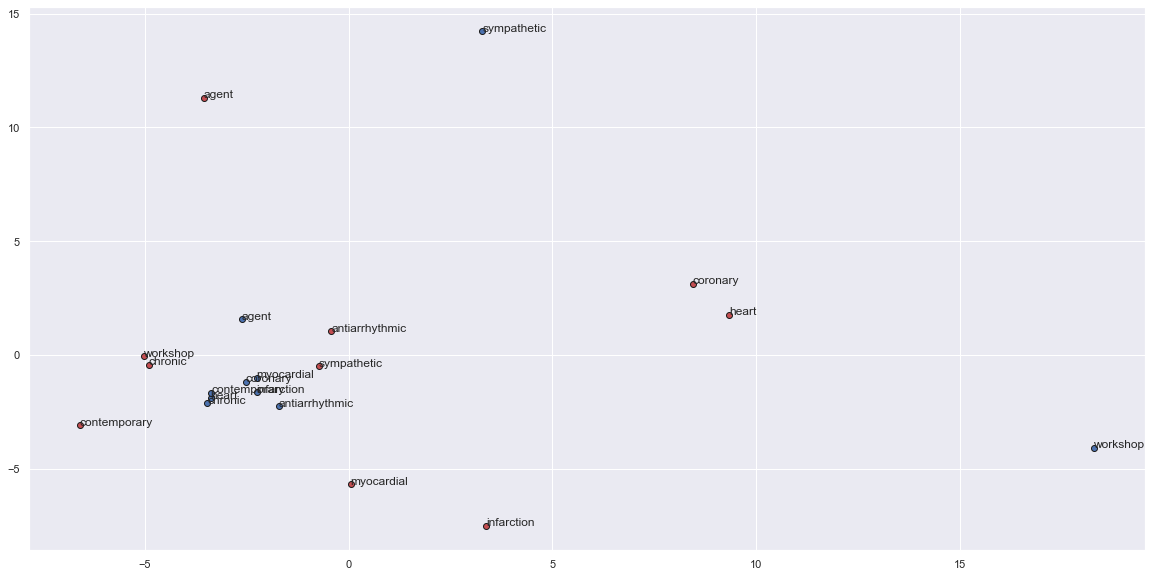

In [162]:
display_pca_scatterplot(words_embeddings_first_layer, words_embedding_last_layer, chosen_words)

In [163]:
from sklearn.metrics.pairwise import cosine_similarity

cos_similarity=cosine_similarity(words_embeddings_first_layer, words_embedding_last_layer) #for our chosen tokens 
cos_similarity

array([[ 0.19202164,  0.07507092,  0.08016632,  0.02938302,  0.08819504,
         0.07551402,  0.09822591,  0.06006809, -0.07290285,  0.09347519],
       [ 0.0449735 ,  0.17098814,  0.01094327,  0.068578  ,  0.034948  ,
         0.02677933,  0.05597704,  0.02712475, -0.00904917,  0.03091537],
       [ 0.0141904 ,  0.00548033,  0.14241168, -0.00801591,  0.07648358,
         0.02580343,  0.0494316 , -0.00445152, -0.01601538,  0.01531509],
       [ 0.12801838,  0.13805915,  0.20344765,  0.19443245,  0.1832051 ,
         0.20506889,  0.17238156,  0.14209884, -0.08193339,  0.18931973],
       [-0.01151964,  0.01921106,  0.04550542,  0.07254877,  0.1989471 ,
         0.02656135,  0.03955097,  0.06361029,  0.02141535,  0.04521756],
       [ 0.12824857,  0.10763521,  0.18500093,  0.01536298,  0.17339139,
         0.30697596,  0.2018977 ,  0.14660074, -0.09587377,  0.21798731],
       [ 0.0476691 ,  0.09055883,  0.08229019,  0.00737176,  0.092198  ,
         0.07323508,  0.2469257 ,  0.04403346

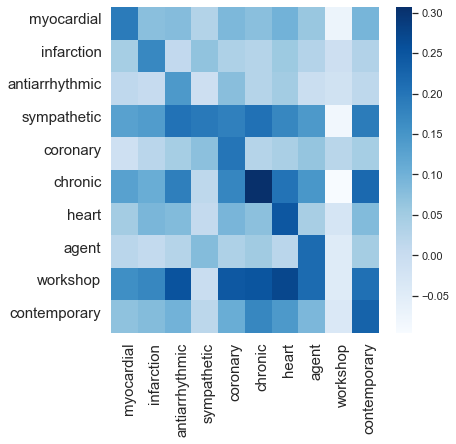

In [164]:
heat_map(chosen_words,chosen_words,cos_similarity)

In [166]:
# Get id's of 10 words of interest (only 4 for now)
chosen_words_n = [ 'hypertensive' , 'cardiovascular', 'calcium','monotherapy', 'medoxomil', 'olmesartan', 'channel', 'pressure' ,'patients', 'treatment']
#, 'mortality' ,'dose', 
#  
idx_chosen_words_n = []
words_embeddings_first_layer_n = []
words_embedding_last_layer_n = []

for word in chosen_words_n:
    idx_n = get_word_idx(sent_n, word)
    idx_chosen_words_n.append(idx_n)
    word_embedding_first_layer_n = get_word_vector(sent_n, idx_n, tokenizer, model, layer_first) #
    word_embedding_last_layer_n = get_word_vector(sent_n, idx_n, tokenizer, model, layer_last)
    words_embeddings_first_layer_n.append(word_embedding_first_layer_n.numpy())
    words_embedding_last_layer_n.append(word_embedding_last_layer_n.numpy())

#print(idx_chosen_words)

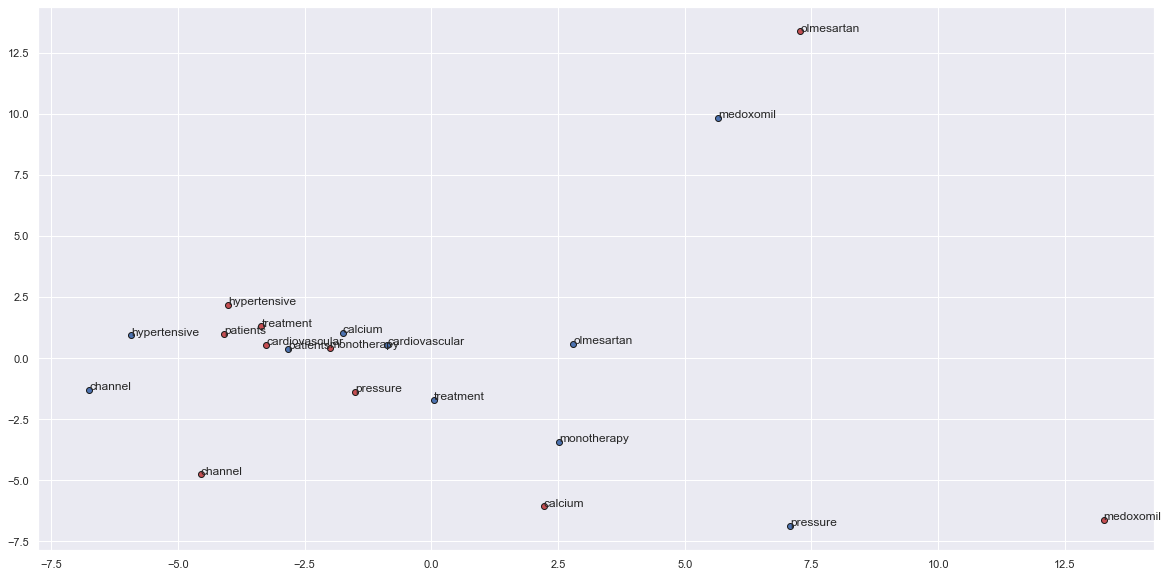

In [167]:
display_pca_scatterplot(words_embeddings_first_layer_n, words_embedding_last_layer_n, chosen_words_n)

In [168]:
from sklearn.metrics.pairwise import cosine_similarity

cos_similarity=cosine_similarity(words_embeddings_first_layer_n, words_embedding_last_layer_n) #for our chosen tokens 
cos_similarity

array([[ 0.25044578,  0.04863486, -0.0213722 ,  0.05504186,  0.06924863,
         0.03177615,  0.0695158 , -0.00542879,  0.08021548,  0.09693761],
       [ 0.0613522 ,  0.1925906 ,  0.0411321 ,  0.02405436,  0.01313506,
        -0.01345543,  0.03436107,  0.03661279,  0.01966976,  0.0009381 ],
       [-0.03519686,  0.00557046,  0.21737508,  0.05487059,  0.08168712,
         0.00425342,  0.02434376,  0.05288609,  0.01986306,  0.00158586],
       [ 0.10188167,  0.16621083,  0.12764806,  0.3204203 ,  0.12425925,
         0.15602687,  0.06086031,  0.12288264,  0.15226613,  0.16788632],
       [ 0.012065  , -0.00949663,  0.04265867, -0.02473964,  0.19216467,
         0.0029847 ,  0.01543416,  0.01710767, -0.01736325, -0.05064379],
       [-0.01271927, -0.00073327, -0.01982434, -0.00865491,  0.00536603,
         0.18784633,  0.01142037,  0.00615281, -0.03228215,  0.00303901],
       [ 0.0926762 ,  0.02522916,  0.10276596,  0.04568846,  0.01765274,
         0.01697003,  0.25060457,  0.06931998

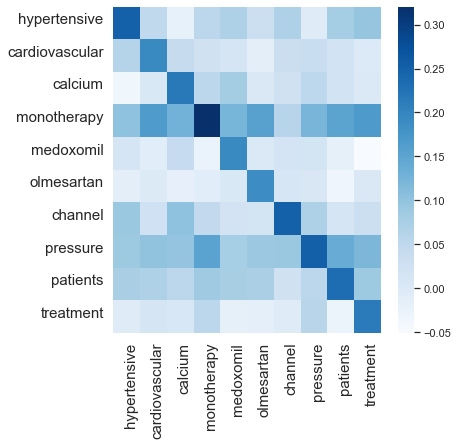

In [169]:
heat_map(chosen_words_n,chosen_words_n,cos_similarity)

In [170]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [171]:
call_html()
head_view(attention, tokens)
#model_view(attention, tokens)

In [ ]:
cases = pickle.load(open("cases.bin", "rb"))
cases_training = pickle.load(open("cases_training.bin", "rb"))
detailed_description = pickle.load(open("detailed_description.bin", "rb"))

queryid=[]
docid=[]
embeddings=[]
y_value=[]

for caseid in cases_training:
    print(cases[caseid])
    aux = eval.relevance_judgments.loc[eval.relevance_judgments['query_id'] == int(caseid)]
    juddocs = aux['docid'].tolist()
    relevances = aux['rel'].tolist()
    y_index=0
    for doc in juddocs:
        print(doc) 
        doc_index=0
        for d in doc_ids:
            if doc == d:
                queryid.append(caseid)
                docid.append(doc)
                y_value.append(relevances[y_index])
                sentence= [cases[caseid].strip(), detailed_description[doc_index].strip().split('.')[0]]
                word_embedding = get_word_vector(sentence, 0, tokenizer, model, [-1])
                embeddings.append(word_embedding.numpy())
                break
            doc_index+=1
        y_index+=1
    '''       
    for rel in relevances:
        if rel == 0:
            y_training.append(rel)
        elif rel == 1 or rel == 2:
            y_training.append(1)
    break

    #case_rel.append(ids.index(docid))
    '''    

58-year-old woman with hypertension and obesity presents with exercise-related episodic chest pain radiating to the back.
       		
NCT00000408
{'input_ids': tensor([[  101,  5388,  1011,  2095,  1011,  2214,  2450,  2007, 23760, 29048,
          1998, 24552,  7534,  2007,  6912,  1011,  3141,  4958, 19565, 14808,
          3108,  3255, 23229,  2000,  1996,  2067,  1012,   102,  2023,  2817,
          2097,  4503,  1998, 16157,  1999,  1037,  6721,  3550,  3979,  1037,
          2659,  2067,  3255,  8830,  2008,  4473,  5739,  2000,  2831,  2007,
          2169,  2060,  1998,  2007,  2740,  8390,  3081,  2019,  4274,  6594,
          2177,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         

In [ ]:
y_transformed=[]

for val in y_value:
    if val == 0:
        y_transformed.append(val)
    elif val == 1 or val == 2:
        y_transformed.append(1)

In [ ]:
candidates = {'query': queryid,
              'doc': docid,
              'embeddings': embeddings,
              'Y': y_transformed}
              
df = pd.DataFrame(candidates, columns=['query', 'doc',
                                       'embeddings', 'Y'])

print(df)

       query          doc                                         embeddings  \
0      20141  NCT00000408  [0.38645178, -0.821175, 0.6702614, -0.29971233...   
1      20141  NCT00000492  [0.72893274, -0.84355855, 0.22579116, -0.77504...   
2      20141  NCT00000501  [0.43844944, -0.6552277, 0.34449455, -0.695888...   
3      20141  NCT00001853  [0.29129943, -0.8812773, 0.39853787, -0.200720...   
4      20141  NCT00004727  [0.8736862, -0.18110561, 0.828001, -0.17936054...   
...      ...          ...                                                ...   
3291  201518  NCT02606253  [-0.20702402, -0.6680083, -0.53844357, -0.0634...   
3292  201518  NCT02610426  [-0.5639841, -0.011720874, -0.6503097, 0.00387...   
3293  201518  NCT02614417  [-0.7759046, 0.5336211, -0.24075371, -0.405177...   
3294  201518  NCT02620384  [0.03891194, 0.3331023, -0.13940343, -0.231517...   
3295  201518  NCT02632656  [-0.4706456, -0.72135705, -0.21596895, -0.2882...   

      Y  
0     0  
1     1  
2     0  

In [ ]:
embeddings[0]

array([ 3.86451781e-01, -8.21174979e-01,  6.70261383e-01, -2.99712330e-01,
        6.36668324e-01, -1.77962780e-01, -3.82742137e-02,  3.48207712e-01,
        5.04784465e-01,  5.79389691e-01,  3.03016394e-01, -6.70940995e-01,
        3.48592639e-01, -9.26640570e-01,  3.31588417e-01,  8.84822726e-01,
        5.01238585e-01, -5.51154852e-01, -1.91542029e-01, -3.60388100e-01,
       -3.38432968e-01, -6.41636014e-01,  2.43280619e-01,  1.29913449e+00,
        6.84986353e-01, -4.43328708e-01,  8.28731060e-01, -4.20389712e-01,
       -5.60798496e-02, -4.36372459e-01,  1.58056244e-02,  3.50678205e-01,
       -1.76979959e-01, -6.95573747e-01,  1.06287979e-01,  6.66561723e-01,
       -4.62962866e-01,  1.62554473e-01, -3.40636462e-01,  4.17380810e-01,
        1.26994520e-01, -1.80069655e-01, -6.13193035e-01, -2.42373332e-01,
        3.14616263e-01, -6.29127324e-02,  4.01713669e-01, -1.50238916e-01,
        5.17844319e-01, -3.68808389e-01, -1.36993718e+00,  3.36926520e-01,
       -5.53507030e-01, -